# Pyro

In [1]:
use_cuda = False

In [2]:
# import pymc3 as pm
import numpy as np
import pandas as pd
# from theano import shared
import scipy.stats as stats
import matplotlib.pyplot as plt
import arviz as az

In [3]:
az.style.use('arviz-darkgrid')

In [4]:
import torch
if use_cuda and torch.cuda.is_available():
    print("PyTorch backend {}".format('gpu'))
    device = torch.device('cuda:0')
#     torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    use_cuda = False
    device = torch.device('cpu')
    print("PyTorch backend {}".format('cpu'))

PyTorch backend cpu


In [184]:
import logging
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.infer import MCMC, NUTS, Predictive, TracePredictive
from pyro.infer.mcmc.util import initialize_model, summary
from pyro import deterministic

logging.basicConfig(format='%(message)s', level=logging.INFO)
pyro.enable_validation(__debug__)
pyro.set_rng_seed(0)

## Simple linear regression

In [6]:
np.random.seed(1)
N = 100
alpha_real = 2.5
beta_real = 0.9
eps_real = np.random.normal(0, 0.5, size=N)

x = np.random.normal(10, 1, N)
y_real = alpha_real + beta_real * x
y = y_real + eps_real

# we can center the data
#x = x - x.mean()
# or standardize the data
#x = (x - x.mean())/x.std()
#y = (y - y.mean())/y.std()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  


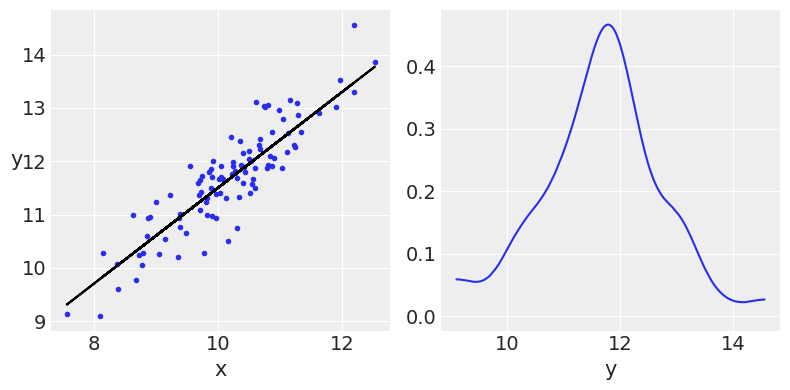

In [7]:
_, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(x, y, 'C0.')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y', rotation=0)
ax[0].plot(x, y_real, 'k')
az.plot_kde(y, ax=ax[1])
ax[1].set_xlabel('y')
plt.tight_layout()
plt.savefig('B11197_03_02.png', dpi=300)

In [8]:
def model_g(x, y=None):
    alpha = pyro.sample('alpha', dist.Normal(loc=0, scale=10)).to(device)
    beta = pyro.sample('beta', dist.Normal(loc=0, scale=1)).to(device)
    eps = pyro.sample('eps', dist.HalfCauchy(5.)).to(device)
    
    mu = alpha + beta * x
    
    # key issue: don't use y other than 'obs'
    if use_cuda:
        with pyro.plate("plate", size=x.shape[0], use_cuda=use_cuda):
            return pyro.sample("obs", dist.Normal(loc=mu, scale=eps), obs=y)
    else:
        with pyro.plate("plate", size=x.shape[0], use_cuda=None):
            return pyro.sample("obs", dist.Normal(loc=mu, scale=eps), obs=y)

In [9]:
x_tensor = torch.from_numpy(x).to(device)
y_tensor = torch.from_numpy(y).to(device)
x_tensor.shape, y_tensor.shape

(torch.Size([100]), torch.Size([100]))

### MCMC

In [10]:
%%time
pyro.clear_param_store() 

nuts_kernel = NUTS(model_g)
mcmc = MCMC(nuts_kernel, num_samples=2000, warmup_steps=1000, num_chains=1)
# mcmc = MCMC(nuts_kernel, num_samples=200, warmup_steps=50, num_chains=1)
mcmc.run(x_tensor, y_tensor)
posterior_samples = mcmc.get_samples()

Sample: 100%|██████████| 3000/3000 [05:52,  8.51it/s, step size=6.65e-02, acc. prob=0.928]

CPU times: user 4min 13s, sys: 742 ms, total: 4min 14s
Wall time: 5min 52s


In [11]:
mcmc.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      2.11      0.49      2.11      1.27      2.83    620.71      1.00
      beta      0.94      0.05      0.94      0.87      1.02    620.37      1.00
       eps      0.45      0.03      0.45      0.40      0.51    738.61      1.01

Number of divergences: 0


In [12]:
posterior_samples

{'alpha': tensor([2.0871, 2.4184, 2.2507,  ..., 2.9435, 2.0265, 2.4587],
        dtype=torch.float64),
 'beta': tensor([0.9404, 0.9144, 0.9259,  ..., 0.8650, 0.9483, 0.9074],
        dtype=torch.float64),
 'eps': tensor([0.4298, 0.4214, 0.4330,  ..., 0.4071, 0.4465, 0.4540],
        dtype=torch.float64)}

In [13]:
posterior_predictive = Predictive(model_g, posterior_samples)(x_tensor, None)
posterior_predictive

{'obs': tensor([[11.1616, 12.7404, 11.5644,  ..., 12.2463, 12.1984, 12.4620],
         [10.7317, 12.8908, 12.3954,  ..., 11.7598, 11.8666, 12.7727],
         [11.3841, 13.5525, 11.4471,  ..., 11.7571, 12.8254, 12.4667],
         ...,
         [10.8538, 12.7820, 12.1357,  ..., 11.8012, 12.4146, 12.6566],
         [10.0625, 12.3600, 11.2611,  ..., 11.5836, 12.2313, 11.7456],
         [10.7993, 12.9111, 11.4385,  ..., 11.2095, 13.0845, 11.9417]],
        dtype=torch.float64)}

### Summary table

#### version 1

In [48]:
# https://pyro.ai/examples/baseball.html
def get_summary_table(posterior, sites, diagnostics=False, group_by_chain=False, prob=0.9):
    """
    Return summarized statistics for each of the ``sites`` in the
    traces corresponding to the approximate posterior.
    """
    site_stats = {}

    for site_name in sites:
        marginal_site = posterior[site_name].cpu()

        site_summary = summary({site_name: marginal_site}, prob=prob, group_by_chain=group_by_chain)[site_name]
        site_summary = {key: site_summary[key].numpy()   for key in site_summary.keys()}
#         print(site_summary)
        if site_summary["mean"].shape:
            site_df = pd.DataFrame(site_summary)
        else:
            site_df = pd.DataFrame(site_summary, index=[0])
        if not diagnostics:
            site_df = site_df.drop(["n_eff", "r_hat"], axis=1)
        site_stats[site_name] = site_df.astype(float)

    return site_stats

In [15]:
get_summary_table(posterior_predictive, ['obs'])

{'obs':          mean       std     median       5.0%      95.0%
 0   11.118087  0.452643  11.104149  10.442063  11.910457
 1   12.677664  0.467818  12.667279  11.903529  13.427016
 2   11.890403  0.453412  11.887797  11.078531  12.585075
 3   12.082111  0.446221  12.094431  11.342188  12.773197
 4   10.499831  0.461002  10.505557   9.790754  11.265977
 ..        ...       ...        ...        ...        ...
 95   9.979806  0.472105   9.995178   9.184026  10.733438
 96  12.073825  0.456397  12.061918  11.277344  12.773564
 97  11.915132  0.463222  11.918697  11.141426  12.631602
 98  12.294017  0.449500  12.285768  11.571476  13.030922
 99  12.492206  0.450526  12.478545  11.808252  13.259998
 
 [100 rows x 5 columns]}

In [16]:
get_summary_table(posterior_samples, ['alpha', 'beta', 'eps'])

{'alpha':        mean       std    median      5.0%    95.0%
 0  2.106218  0.491215  2.105067  1.273912  2.83025,
 'beta':        mean      std    median     5.0%     95.0%
 0  0.941848  0.04815  0.942108  0.87093  1.022543,
 'eps':        mean       std    median      5.0%    95.0%
 0  0.450461  0.032171  0.448372  0.402336  0.50841}

#### version 2

In [47]:
def get_summary_table_pandas(posterior, sites, percentiles=[.05, 0.25, 0.5, 0.75, 0.95]):
    site_stats = {}

    for site_name in sites:
        values = posterior[site_name].cpu().numpy()
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=percentiles).transpose()
        site_stats[site_name] = describe.astype(float)
    return site_stats

In [18]:
get_summary_table_pandas(posterior_predictive, ['obs'], percentiles=[.05, 0.95])

{'obs':      count       mean       std        min         5%        50%        95%  \
 0   2000.0  11.118087  0.452643   9.639298  10.390777  11.104642  11.862918   
 1   2000.0  12.677664  0.467818  10.802666  11.922852  12.667513  13.447869   
 2   2000.0  11.890403  0.453412  10.246341  11.130886  11.888038  12.657108   
 3   2000.0  12.082111  0.446221  10.787910  11.345201  12.095091  12.779902   
 4   2000.0  10.499831  0.461002   8.907770   9.722181  10.505850  11.231619   
 ..     ...        ...       ...        ...        ...        ...        ...   
 95  2000.0   9.979806  0.472105   8.241593   9.179665   9.995742  10.732234   
 96  2000.0  12.073825  0.456397  10.412568  11.339564  12.062002  12.842773   
 97  2000.0  11.915132  0.463222  10.367068  11.148363  11.918922  12.651562   
 98  2000.0  12.294017  0.449500  10.306364  11.569218  12.285898  13.030650   
 99  2000.0  12.492206  0.450526  10.997932  11.778845  12.479370  13.234765   
 
           max  
 0   12.705521

In [19]:
get_summary_table_pandas(posterior_samples, ['alpha', 'beta', 'eps'], percentiles=[.05, 0.95])

{'alpha':     count      mean       std       min        5%       50%       95%      max
 0  2000.0  2.106218  0.491215  0.179384  1.322825  2.105159  2.883476  3.94537,
 'beta':     count      mean      std       min        5%       50%       95%       max
 0  2000.0  0.941848  0.04815  0.759654  0.865034  0.942119  1.017336  1.131629,
 'eps':     count      mean       std       min        5%       50%       95%      max
 0  2000.0  0.450461  0.032171  0.366297  0.399953  0.448407  0.506353  0.58833}

### plot trace

In [20]:
num_samples=2000
prior = Predictive(model_g, num_samples=num_samples).get_samples(x_tensor, y_tensor)

In [21]:
pyro_data = az.from_pyro(
    mcmc,
    prior=prior,
    posterior_predictive=posterior_predictive
)
pyro_data

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

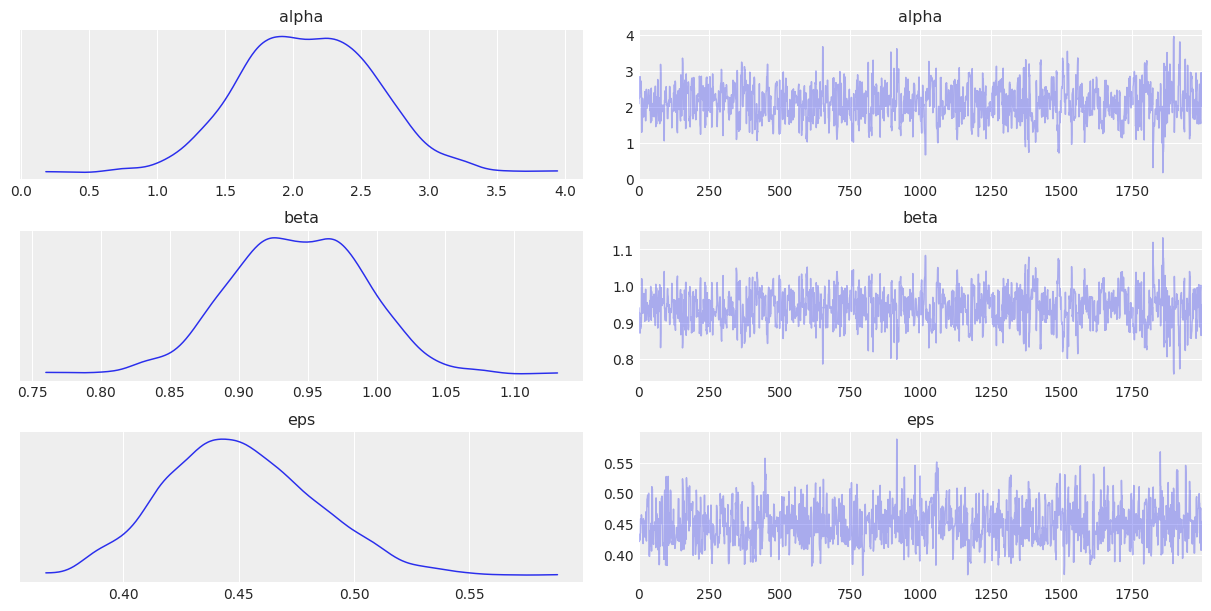

In [22]:
az.plot_trace(pyro_data, var_names=['alpha', 'beta', 'eps']);

### record trace

In [23]:
trace = Predictive(model_g, posterior_samples).get_vectorized_trace(x_tensor, y_tensor)
trace.compute_log_prob()
trace.nodes["obs"]["log_prob"]

tensor([[-1.9803, -0.3993, -0.2740,  ..., -0.0751, -0.3761, -0.3444],
        [-1.6664, -0.4732, -0.3649,  ..., -0.0608, -0.4692, -0.2631],
        [-1.8470, -0.4045, -0.2981,  ..., -0.0820, -0.3924, -0.3412],
        ...,
        [-1.5114, -0.4036, -0.3760,  ..., -0.0301, -0.4446, -0.2778],
        [-1.8174, -0.4641, -0.3278,  ..., -0.1127, -0.4349, -0.3224],
        [-1.6159, -0.4223, -0.3472,  ..., -0.1298, -0.4241, -0.3604]],
       dtype=torch.float64)

### SVI
#### Using an AutoGuide

In [24]:
autoguide = True

if autoguide:
    from pyro.infer.autoguide import AutoDiagonalNormal
    guide = AutoDiagonalNormal(model_g)
else:
    from torch.distributions import constraints
    def guide(x, y):
        alpha_loc = pyro.param('alpha_loc', torch.tensor(0.)).to(device)
        alpha_scale = pyro.param('alpha_scale', torch.tensor(1.),
                             constraint=constraints.positive).to(device)
        eps_loc = pyro.param('eps_loc', torch.tensor(1.),
                                 constraint=constraints.positive).to(device)
        beta_loc = pyro.param('beta_loc', torch.tensor(0.)).to(device)
        beta_scale = pyro.param('beta_scale', torch.tensor(1.),
                             constraint=constraints.positive).to(device)
        
        alpha = pyro.sample("alpha", dist.Normal(alpha_loc, alpha_scale)).to(device)
        beta = pyro.sample("beta", dist.Normal(beta_loc, beta_scale)).to(device)
        eps = pyro.sample("eps", dist.Normal(eps_loc, torch.tensor(0.05))).to(device)
        mu = alpha + beta * x

In [25]:
# optimizing
from pyro.infer import SVI, Trace_ELBO

adam = pyro.optim.Adam({"lr": 0.03})
svi = SVI(model_g, guide, adam, loss=Trace_ELBO())

In [26]:
num_iterations = 2000

In [27]:
%%time
pyro.clear_param_store()
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(x_tensor, y_tensor)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(y_tensor)))

[iteration 0001] loss: 3.9207
[iteration 0101] loss: 1.1316
[iteration 0201] loss: 0.7603
[iteration 0301] loss: 0.7561
[iteration 0401] loss: 0.8037
[iteration 0501] loss: 0.7733
[iteration 0601] loss: 0.7905
[iteration 0701] loss: 0.8333
[iteration 0801] loss: 0.7941
[iteration 0901] loss: 0.8004
[iteration 1001] loss: 0.7507
[iteration 1101] loss: 0.8366
[iteration 1201] loss: 0.7792
[iteration 1301] loss: 0.7874
[iteration 1401] loss: 0.7477
[iteration 1501] loss: 0.7727
[iteration 1601] loss: 0.7624
[iteration 1701] loss: 0.7872
[iteration 1801] loss: 0.7795
[iteration 1901] loss: 0.7552
CPU times: user 6.81 s, sys: 9.79 ms, total: 6.82 s
Wall time: 6.81 s


In [28]:
# stop updating weight/parameters
guide.requires_grad_(False)

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

AutoDiagonalNormal.loc Parameter containing:
tensor([ 2.0801,  0.9558, -0.7933])
AutoDiagonalNormal.scale tensor([0.0449, 0.0046, 0.0664])


In [29]:
guide.quantiles([0.25, 0.5, 0.75])

{'alpha': [tensor(2.0498), tensor(2.0801), tensor(2.1104)],
 'beta': [tensor(0.9527), tensor(0.9558), tensor(0.9589)],
 'eps': [tensor(0.4326), tensor(0.4524), tensor(0.4731)]}

In [30]:
num_sumples = 2000
predictive = Predictive(model_g, guide=guide, num_samples=num_sumples)
svi_samples = {k: v.reshape(num_samples).detach().cpu()
               for k, v in predictive(x_tensor, y_tensor).items()
               if k != "obs"}
svi_samples

{'alpha': tensor([2.0535, 2.0542, 2.1407,  ..., 2.0665, 2.0980, 2.1078]),
 'beta': tensor([0.9595, 0.9573, 0.9539,  ..., 0.9550, 0.9476, 0.9577]),
 'eps': tensor([0.4266, 0.4009, 0.4142,  ..., 0.4459, 0.5461, 0.4277])}

In [31]:
svi_posterior_predictive = {k: v.detach().cpu()
               for k, v in predictive(x_tensor).items()
               if k == "obs"}
svi_posterior_predictive

{'obs': tensor([[11.3923, 12.9567, 12.1434,  ..., 12.4606, 11.9926, 12.8392],
         [12.2371, 13.2514, 13.2820,  ..., 12.3486, 12.6890, 12.9097],
         [10.4603, 12.5722, 11.0483,  ..., 12.5771, 12.6918, 12.3742],
         ...,
         [10.9641, 12.6713, 11.5232,  ..., 11.7699, 12.4255, 13.0899],
         [10.7574, 12.6036, 11.3965,  ..., 12.9159, 12.3667, 12.2256],
         [10.4723, 11.8982, 13.0225,  ..., 12.3425, 12.3998, 12.4263]],
        dtype=torch.float64)}

### Summary table

In [32]:
get_summary_table(svi_posterior_predictive, ['obs'])

{'obs':          mean       std     median       5.0%      95.0%
 0   11.204560  0.453794  11.209095  10.418192  11.867963
 1   12.801731  0.465164  12.810372  12.082296  13.586762
 2   12.017934  0.465662  12.014772  11.269817  12.781246
 3   12.207997  0.446737  12.202276  11.512216  12.977747
 4   10.601961  0.451551  10.604318   9.859381  11.324108
 ..        ...       ...        ...        ...        ...
 95  10.054513  0.457781  10.053466   9.292552  10.793156
 96  12.219736  0.464803  12.218116  11.381760  12.879622
 97  12.031254  0.460064  12.033475  11.200030  12.710534
 98  12.395738  0.467764  12.406089  11.683948  13.228619
 99  12.653066  0.470577  12.664932  11.954950  13.466580
 
 [100 rows x 5 columns]}

In [33]:
get_summary_table(posterior_samples, ['alpha', 'beta', 'eps'])

{'alpha':        mean       std    median      5.0%    95.0%
 0  2.106218  0.491215  2.105067  1.273912  2.83025,
 'beta':        mean      std    median     5.0%     95.0%
 0  0.941848  0.04815  0.942108  0.87093  1.022543,
 'eps':        mean       std    median      5.0%    95.0%
 0  0.450461  0.032171  0.448372  0.402336  0.50841}

### plot trace

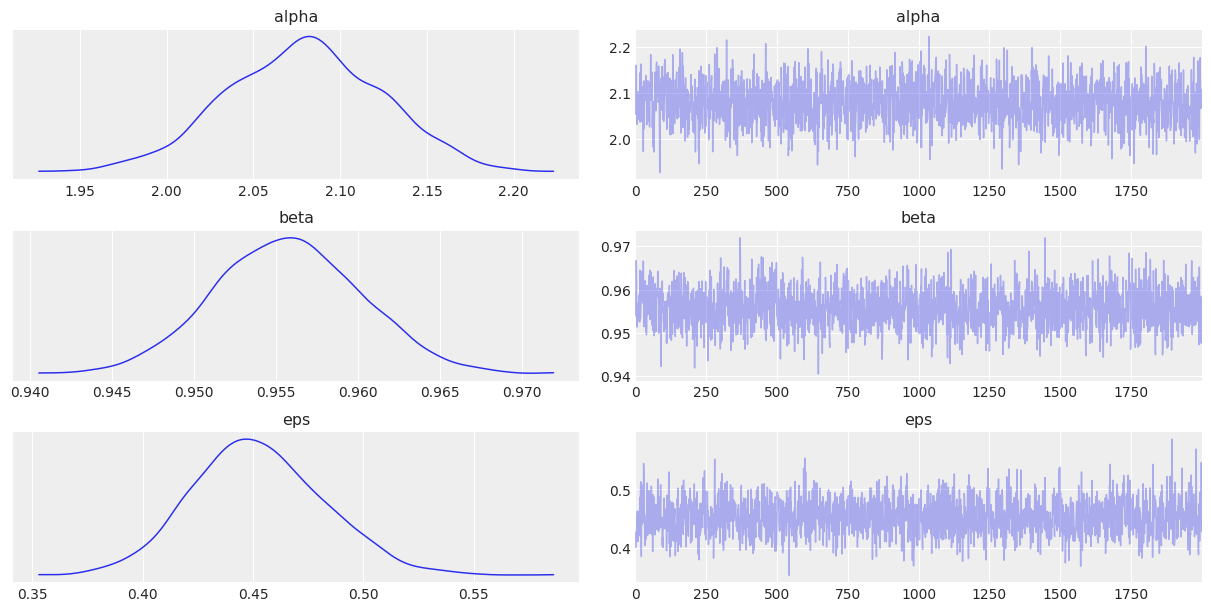

In [34]:
trace_g_svi = az.convert_to_inference_data(svi_samples)
az.plot_trace(trace_g_svi, compact=True);

### detailed info is here. https://pyro.ai/examples/bayesian_regression_ii.html#

https://pyro.ai/examples/bayesian_regression.html#Using-an-AutoGuide

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


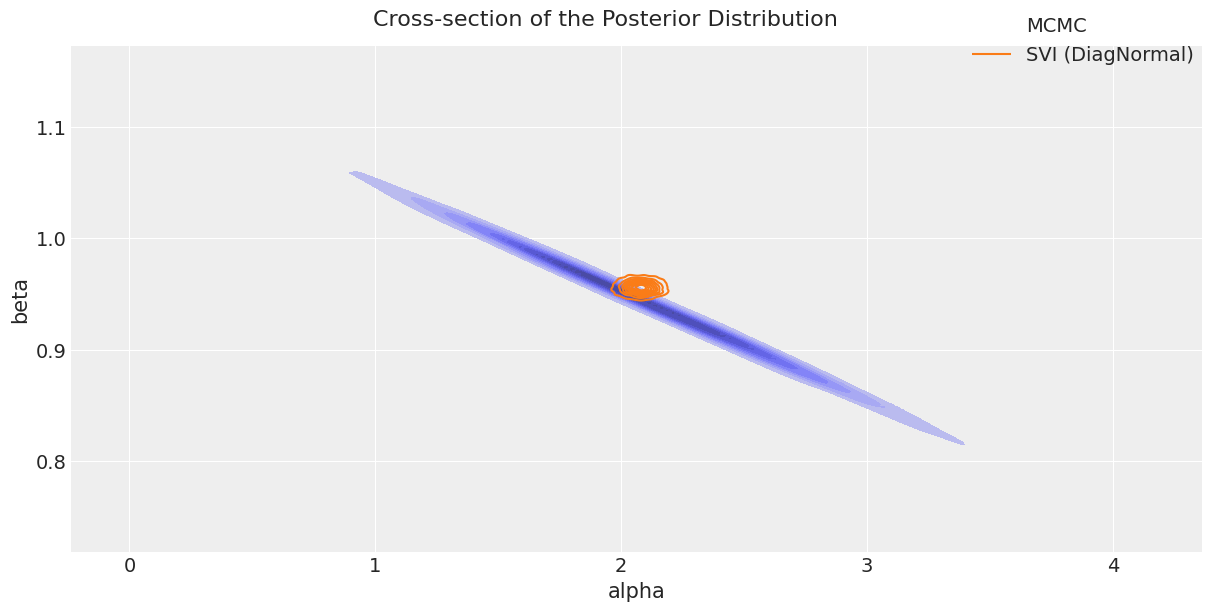

In [35]:
import seaborn as sns
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
fig.suptitle("Cross-section of the Posterior Distribution", fontsize=16)
# mcmc
sns.kdeplot(posterior_samples["alpha"], posterior_samples["beta"],
            ax=axs, shade=True, label="MCMC")
# SVI
sns.kdeplot(svi_samples["alpha"], svi_samples["beta"], ax=axs, label="SVI (DiagNormal)")
# sns.kdeplot(hmc_samples["bR"], hmc_samples["bAR"], ax=axs[1], shade=True, label="HMC")
# sns.kdeplot(svi_samples["bR"], svi_samples["bAR"], ax=axs[1], label="SVI (DiagNormal)")
axs.set(xlabel="alpha", ylabel="beta")#, xlim=(0.0, 5.0), ylim=(0.55, 1.0))
handles, labels = axs.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

### interpreting the posterior

In [36]:
draws = range(0, len(posterior_samples['alpha']), 10)
posterior_samples['alpha'].shape

torch.Size([2000])

In [37]:
posterior_samples['alpha'][draws].shape

torch.Size([200])

In [38]:
def plot_posterior_1(x, y, posterior_samples):
    plt.plot(x, y, 'C0.')

    alpha_m = posterior_samples['alpha'].mean()
    beta_m = posterior_samples['beta'].mean()

    draws = range(0, len(posterior_samples['alpha']), 10)
    plt.plot(x, posterior_samples['alpha'][draws] + posterior_samples['beta'][draws]
             * x[:, np.newaxis], c='gray', alpha=0.5)

    plt.plot(x, alpha_m + beta_m * x, c='k',
             label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

    plt.xlabel('x')
    plt.ylabel('y', rotation=0)
    plt.legend()
#     plt.savefig('B11197_03_05.png', dpi=300)

#### MCMC

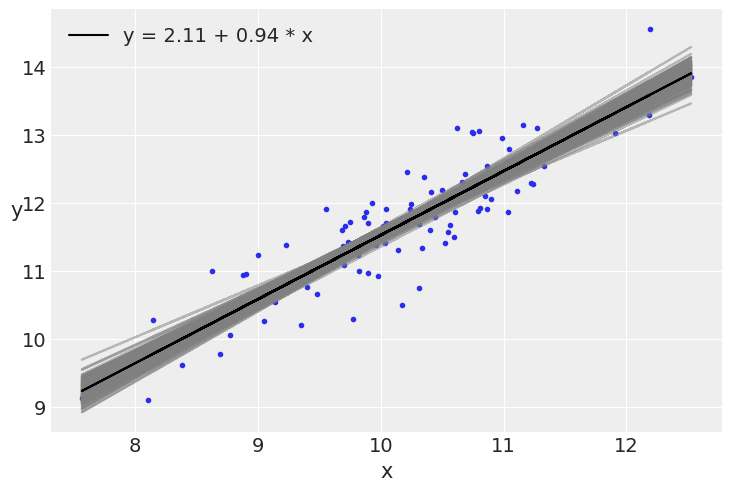

In [39]:
plot_posterior_1(x, y, posterior_samples)

#### SVI

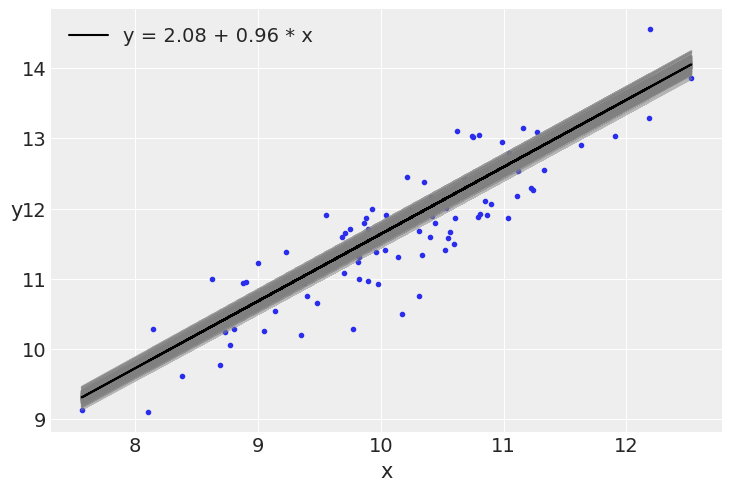

In [40]:
plot_posterior_1(x, y, svi_samples)

In [41]:
def plot_posterior_2(x, y, posterior_samples, credible_interval=0.98):
    fig, ax = plt.subplots()
    alpha_m = posterior_samples['alpha'].mean()
    beta_m = posterior_samples['beta'].mean()
    
    ax.plot(x, alpha_m + beta_m * x, c='k',
             label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')
    
    out = np.dot(posterior_samples['beta'].reshape(-1,1).numpy(), x.reshape(1,-1)) + posterior_samples['alpha'].reshape(-1,1).numpy()
    sig = az.plot_hpd(x, out, hdi_prob=credible_interval, color='k', ax=ax)

    plt.xlabel('x')
    plt.ylabel('y', rotation=0)
    plt.legend()
#     plt.savefig('B11197_03_06.png', dpi=300)

/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


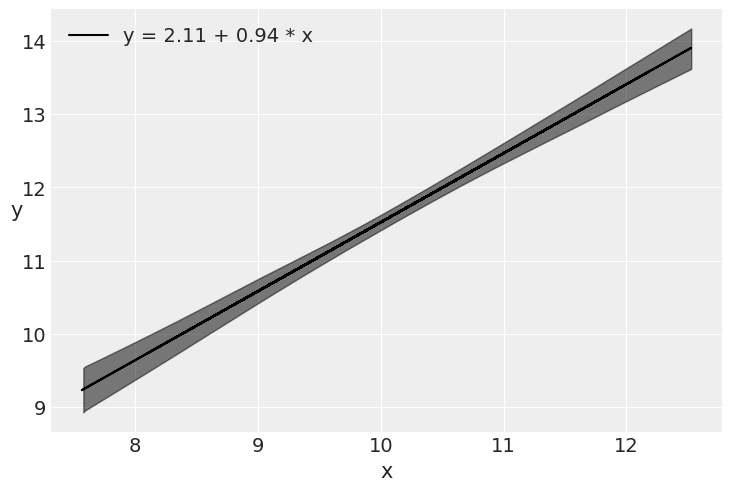

In [42]:
# MCMC
plot_posterior_2(x, y, posterior_samples)

/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


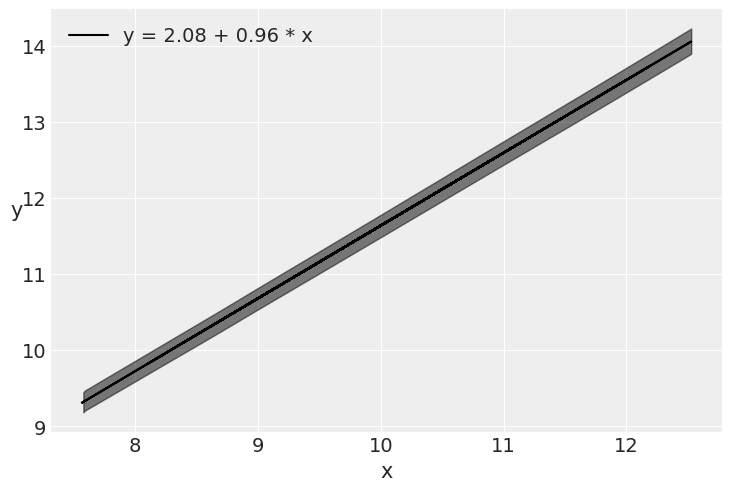

In [43]:
# SVI
plot_posterior_2(x, y, svi_samples)

In [44]:
def plot_posterior_3(x, y, posterior_samples, posterior_predictive):
    fig, ax = plt.subplots()
    
    ax.plot(x, y, 'b.')
    
    alpha_m = posterior_samples['alpha'].mean()
    beta_m = posterior_samples['beta'].mean()
    
    ax.plot(x, alpha_m + beta_m * x, c='k',
             label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')
    
#     sig = az.plot_hpd(x, posterior_predictive['obs'], credible_interval=0.98, color='k', ax=ax)
    
    az.plot_hpd(x, posterior_predictive['obs'], hdi_prob=0.5, color='gray',ax=ax)
    az.plot_hpd(x, posterior_predictive['obs'], color='gray',ax=ax)
    
    plt.xlabel('x')
    plt.ylabel('y', rotation=0)
    plt.legend()
#     plt.savefig('B11197_03_06.png', dpi=300)

/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


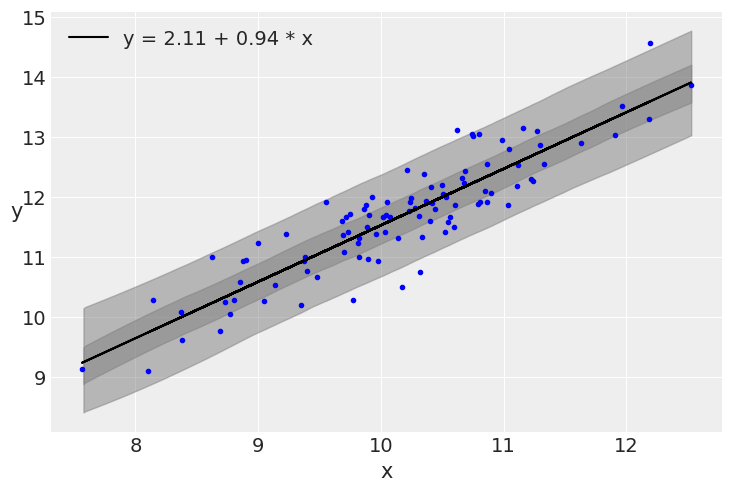

In [45]:
# MCMC
plot_posterior_3(x, y, posterior_samples, posterior_predictive)

/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


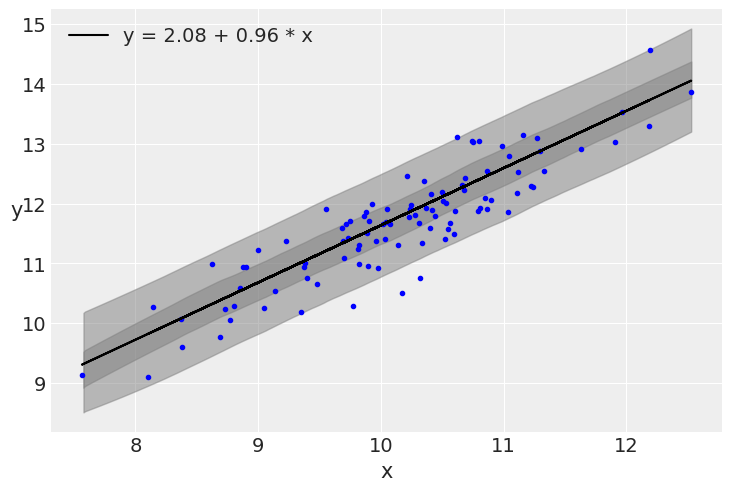

In [46]:
# SVI
plot_posterior_3(x, y, svi_samples, svi_posterior_predictive)

### The multivariate normal distribution 
Actually the bivariate

In [ ]:
# sigma_x1 = 1
# sigmas_x2 = [1, 2]
# rhos = [-0.90, -0.5, 0, 0.5, 0.90]

# k, l = np.mgrid[-5:5:.1, -5:5:.1]
# pos = np.empty(k.shape + (2,))
# pos[:, :, 0] = k
# pos[:, :, 1] = l

# f, ax = plt.subplots(len(sigmas_x2), len(rhos),
#                      sharex=True, sharey=True, figsize=(12, 6),
#                      constrained_layout=True)
# for i in range(2):
#     for j in range(5):
#         sigma_x2 = sigmas_x2[i]
#         rho = rhos[j]
#         cov = [[sigma_x1**2, sigma_x1*sigma_x2*rho],
#                [sigma_x1*sigma_x2*rho, sigma_x2**2]]
#         rv = stats.multivariate_normal([0, 0], cov)
#         ax[i, j].contour(k, l, rv.pdf(pos))
#         ax[i, j].set_xlim(-8, 8)
#         ax[i, j].set_ylim(-8, 8)
#         ax[i, j].set_yticks([-5, 0, 5])
#         ax[i, j].plot(0, 0,
#                       label=f'$\\sigma_{{x2}}$ = {sigma_x2:3.2f}\n$\\rho$ = {rho:3.2f}', alpha=0)
#         ax[i, j].legend()
# f.text(0.5, -0.05, 'x_1', ha='center', fontsize=18)
# f.text(-0.05, 0.5, 'x_2', va='center', fontsize=18, rotation=0)
# plt.savefig('B11197_03_08.png', dpi=300)

In [ ]:
# %%time
# data = np.stack((x, y)).T
# with pm.Model() as pearson_model:

#     mu = pm.Normal('mu', mu=data.mean(0), sd=10, shape=2)

#     σ_1 = pm.HalfNormal('σ_1', 10)
#     σ_2 = pm.HalfNormal('σ_2', 10)
#     ρ = pm.Uniform('ρ', -1., 1.)
#     r2 = pm.Deterministic('r2', ρ**2)

#     cov = pm.math.stack(([σ_1**2, σ_1*σ_2*ρ],
#                          [σ_1*σ_2*ρ, σ_2**2]))

#     y_pred = pm.MvNormal('y_pred', mu=mu, cov=cov, observed=data)

#     trace_p = pm.sample(1000)

In [ ]:
# type(trace_p)

In [ ]:
# az.plot_trace(trace_p, var_names=['r2'])
# plt.savefig('B11197_03_9.png', dpi=300)

In [ ]:
# az.summary(trace_p, var_names=['r2'])

## Robust linear regression

In [6]:
ans = pd.read_csv('../data/anscombe.csv')
x_3 = ans[ans.group == 'III']['x'].values
y_3 = ans[ans.group == 'III']['y'].values
x_3 = x_3 - x_3.mean()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  if sys.path[0] == '':


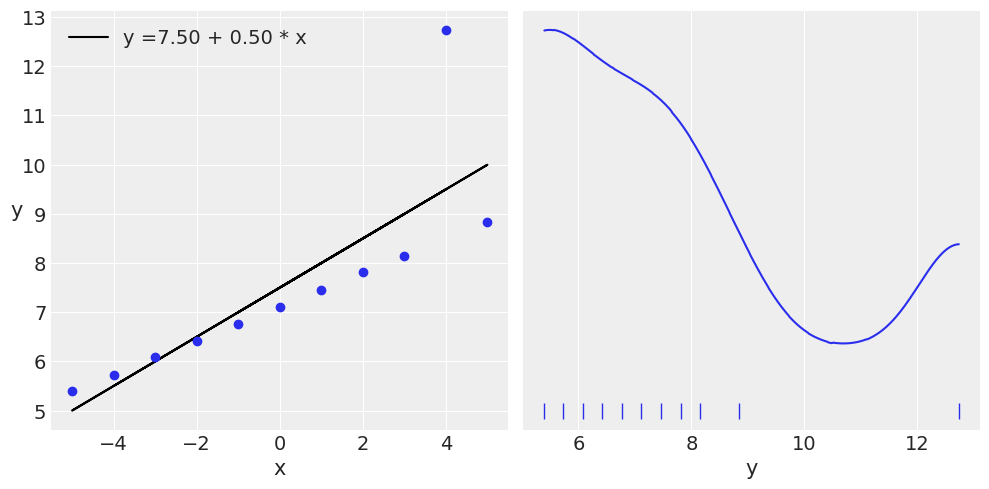

In [7]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
beta_c, alpha_c = stats.linregress(x_3, y_3)[:2]
ax[0].plot(x_3, (alpha_c + beta_c * x_3), 'k',
           label=f'y ={alpha_c:.2f} + {beta_c:.2f} * x')
ax[0].plot(x_3, y_3, 'C0o')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y', rotation=0)
ax[0].legend(loc=0)
az.plot_kde(y_3, ax=ax[1], rug=True)
ax[1].set_xlabel('y')
ax[1].set_yticks([])
plt.tight_layout()
plt.savefig('B11197_03_10.png', dpi=300)

In [88]:
y_3.mean()

7.5

In [89]:
def model_t(x, y=None):
    alpha = pyro.sample('alpha', dist.Normal(loc=7.5, scale=1)).to(device)
    beta = pyro.sample('beta', dist.Normal(loc=0, scale=1)).to(device)
    eps = pyro.sample('eps', dist.HalfNormal(5.)).to(device)
    nu_ = pyro.sample('nu_', dist.Exponential(1/29)).to(device)
    nu = nu_ + 1
    
    mu = alpha + beta * x
    
    if use_cuda:
        with pyro.plate("plate", size=x.shape[0], use_cuda=use_cuda):
            return pyro.sample("obs", dist.StudentT(df=nu, loc=mu, scale=eps), obs=y)
    else:
        with pyro.plate("plate", size=x.shape[0], use_cuda=None):
            return pyro.sample("obs", dist.StudentT(df=nu, loc=mu, scale=eps), obs=y)

In [90]:
x_tensor = torch.from_numpy(x_3).to(device)
y_tensor = torch.from_numpy(y_3).to(device)
x_tensor.shape, y_tensor.shape

(torch.Size([11]), torch.Size([11]))

### MCMC

In [92]:
%%time
pyro.clear_param_store() 

nuts_kernel = NUTS(model_t)
mcmc = MCMC(nuts_kernel, num_samples=2000, warmup_steps=1000, num_chains=1)
# mcmc = MCMC(nuts_kernel, num_samples=200, warmup_steps=50, num_chains=1)
mcmc.run(x_tensor, y_tensor)
posterior_samples = mcmc.get_samples()

Sample: 100%|██████████| 3000/3000 [03:42, 13.50it/s, step size=9.17e-02, acc. prob=0.857]

CPU times: user 3min 42s, sys: 530 ms, total: 3min 42s
Wall time: 3min 42s


In [112]:
mcmc.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      7.11      0.00      7.11      7.11      7.12   1398.77      1.00
      beta      0.35      0.00      0.35      0.34      0.35   1677.03      1.00
       eps      0.00      0.00      0.00      0.00      0.01    460.01      1.00
       nu_      0.22      0.21      0.16      0.00      0.50    604.98      1.00

Number of divergences: 0


In [115]:
posterior_samples

{'alpha': tensor([7.1149, 7.1154, 7.1141,  ..., 7.1144, 7.1138, 7.1158],
        dtype=torch.float64),
 'beta': tensor([0.3449, 0.3455, 0.3447,  ..., 0.3454, 0.3450, 0.3456],
        dtype=torch.float64),
 'eps': tensor([0.0021, 0.0020, 0.0014,  ..., 0.0029, 0.0052, 0.0051],
        dtype=torch.float64),
 'nu_': tensor([0.0839, 0.1249, 0.1971,  ..., 0.1164, 0.0288, 0.0269],
        dtype=torch.float64)}

In [116]:
posterior_predictive = Predictive(model_t, posterior_samples)(x_tensor, None)
posterior_predictive

{'obs': tensor([[7.4573, 6.7684, 8.4974,  ..., 8.1491, 6.4254, 5.7333],
         [7.4582, 6.6916, 8.4973,  ..., 8.1508, 6.4222, 5.7352],
         [7.4593, 6.8610, 8.4916,  ..., 8.1477, 6.4294, 5.7313],
         ...,
         [7.4609, 6.7678, 8.4967,  ..., 8.1505, 6.4310, 5.7045],
         [7.4343, 6.7660, 8.4972,  ..., 8.1481, 6.4302, 5.7303],
         [7.4703, 6.7473, 8.5022,  ..., 8.1606, 6.4410, 5.7282]],
        dtype=torch.float64)}

### Summary table

#### version 1

In [117]:
get_summary_table(posterior_predictive, ['obs'])

{'obs':         mean       std    median      5.0%     95.0%
 0   7.459684  0.049076  7.459518  7.445328  7.476025
 1   6.769780  0.086829  6.768994  6.751183  6.784577
 2   8.497736  0.153800  8.495254  8.478218  8.511079
 3   7.112282  0.127388  7.114454  7.098179  7.127548
 4   7.804542  0.042385  7.804871  7.790790  7.818516
 5   8.841072  0.052876  8.840581  8.823157  8.855693
 6   6.077737  0.055309  6.078357  6.061668  6.093152
 7   5.388443  0.045266  5.387830  5.371311  5.403517
 8   8.150321  0.045656  8.150173  8.132901  8.166154
 9   6.422083  0.077067  6.423689  6.406229  6.438072
 10  5.729368  0.168332  5.733092  5.718928  5.747780}

In [118]:
get_summary_table(posterior_samples, ['alpha', 'beta', 'eps'])

{'alpha':        mean      std   median      5.0%     95.0%
 0  7.114171  0.00143  7.11429  7.111739  7.116185,
 'beta':        mean       std    median      5.0%     95.0%
 0  0.345324  0.000439  0.345277  0.344668  0.346046,
 'eps':        mean       std    median      5.0%     95.0%
 0  0.003264  0.001721  0.002864  0.001121  0.005402}

#### version 2

In [119]:
get_summary_table_pandas(posterior_predictive, ['obs'], percentiles=[.05, 0.95])

{'obs':      count      mean       std       min        5%       50%       95%  \
 0   2000.0  7.459684  0.049076  6.524433  7.443819  7.459519  7.475107   
 1   2000.0  6.769780  0.086829  5.785061  6.751143  6.768995  6.784547   
 2   2000.0  8.497736  0.153800  6.196837  8.478709  8.495259  8.512689   
 3   2000.0  7.112282  0.127388  1.774348  7.098605  7.114456  7.128185   
 4   2000.0  7.804542  0.042385  6.562167  7.791735  7.804872  7.820575   
 5   2000.0  8.841072  0.052876  7.186317  8.824845  8.840582  8.857602   
 6   2000.0  6.077737  0.055309  3.958397  6.062668  6.078359  6.094295   
 7   2000.0  5.388443  0.045266  4.551731  5.371321  5.387832  5.403519   
 8   2000.0  8.150321  0.045656  7.300841  8.133926  8.150174  8.167569   
 9   2000.0  6.422083  0.077067  4.280947  6.407844  6.423689  6.439823   
 10  2000.0  5.729368  0.168332 -1.535386  5.718374  5.733092  5.747328   
 
           max  
 0    8.487042  
 1    9.885337  
 2   14.687914  
 3    8.345077  
 4    

In [120]:
get_summary_table_pandas(posterior_samples, ['alpha', 'beta', 'eps'], percentiles=[.05, 0.95])

{'alpha':     count      mean      std       min        5%      50%       95%       max
 0  2000.0  7.114171  0.00143  7.105888  7.111749  7.11429  7.116229  7.120685,
 'beta':     count      mean       std       min        5%       50%       95%  \
 0  2000.0  0.345324  0.000439  0.343361  0.344704  0.345277  0.346092   
 
         max  
 0  0.348286  ,
 'eps':     count      mean       std       min        5%       50%       95%  \
 0  2000.0  0.003264  0.001721  0.000919  0.001426  0.002864  0.006179   
 
         max  
 0  0.019179  }

### plot trace

In [121]:
num_samples=2000
prior = Predictive(model_t, num_samples=num_samples).get_samples(x_tensor, y_tensor)

In [122]:
pyro_data = az.from_pyro(
    mcmc,
    prior=prior,
    posterior_predictive=posterior_predictive
)
pyro_data

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

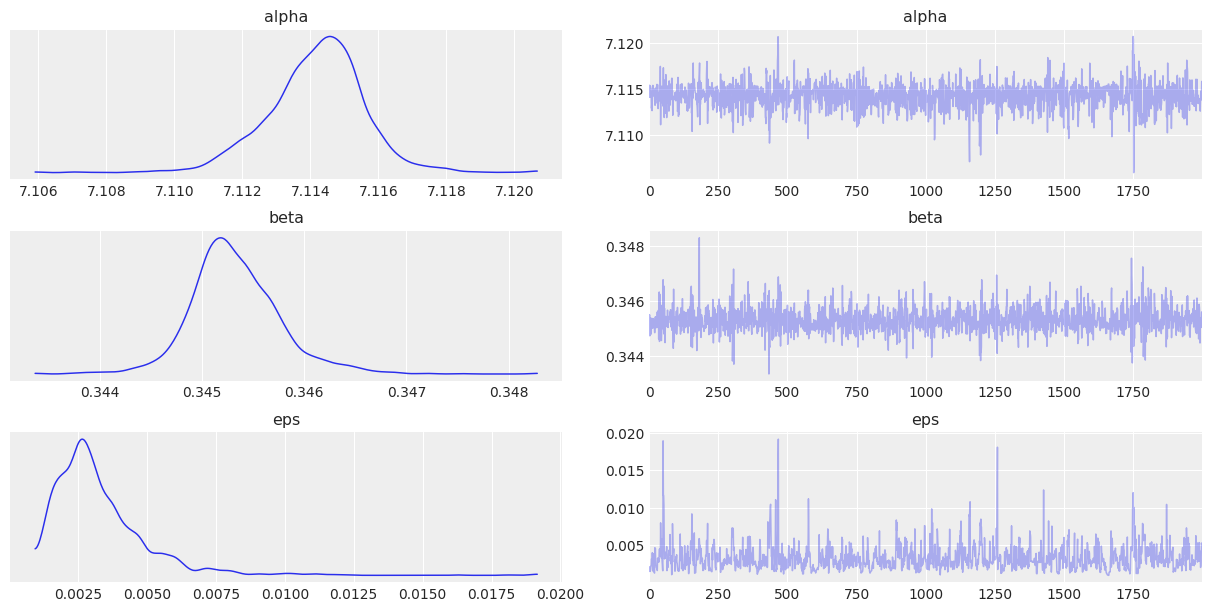

In [123]:
az.plot_trace(pyro_data, var_names=['alpha', 'beta', 'eps']);

### record trace

In [124]:
trace = Predictive(model_t, posterior_samples).get_vectorized_trace(x_tensor, y_tensor)
trace.compute_log_prob()
trace.nodes["obs"]["log_prob"]

tensor([[  5.0439,   5.0510, -10.7587,  ...,   5.0302,   3.1199,   3.0769],
        [  4.9085,   5.0704, -11.0393,  ...,   4.4695,   3.3407,   3.7611],
        [  4.9377,   5.2501, -11.9259,  ...,   4.5792,   2.9579,   2.7453],
        ...,
        [  4.7248,   4.6235, -10.6078,  ...,   4.7129,   3.7838,   4.0337],
        [  4.0634,   4.0561,  -9.4449,  ...,   4.0703,   3.7096,   3.7256],
        [  4.0618,   4.1321,  -9.4568,  ...,   3.9040,   3.5491,   3.7764]],
       dtype=torch.float64)

#### output

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  


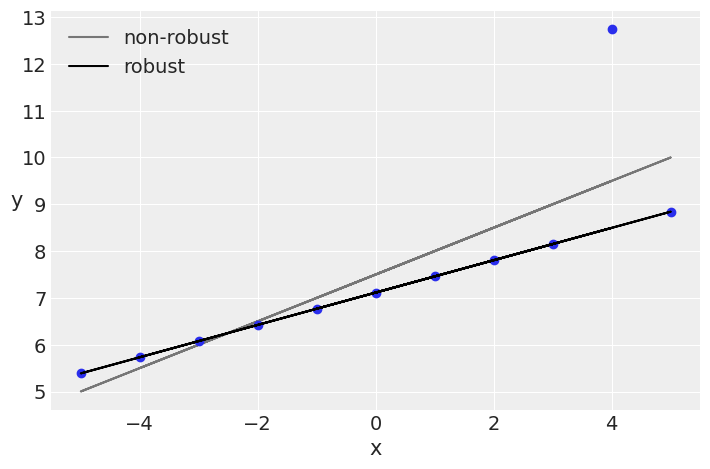

In [128]:
beta_c, alpha_c = stats.linregress(x_3, y_3)[:2]

plt.plot(x_3, (alpha_c + beta_c * x_3), 'k', label='non-robust', alpha=0.5)
plt.plot(x_3, y_3, 'C0o')


alpha_m = get_summary_table(posterior_samples, ['alpha'], diagnostics=False, group_by_chain=False, prob=0.9)['alpha']['mean'].values[0]
beta_m = get_summary_table(posterior_samples, ['beta'], diagnostics=False, group_by_chain=False, prob=0.9)['beta']['mean'].values[0]
plt.plot(x_3, alpha_m + beta_m * x_3, c='k', label='robust')

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend(loc=2)
plt.tight_layout()

# plt.savefig('B11197_03_11.png', dpi=300)

(0.0, 12.0)

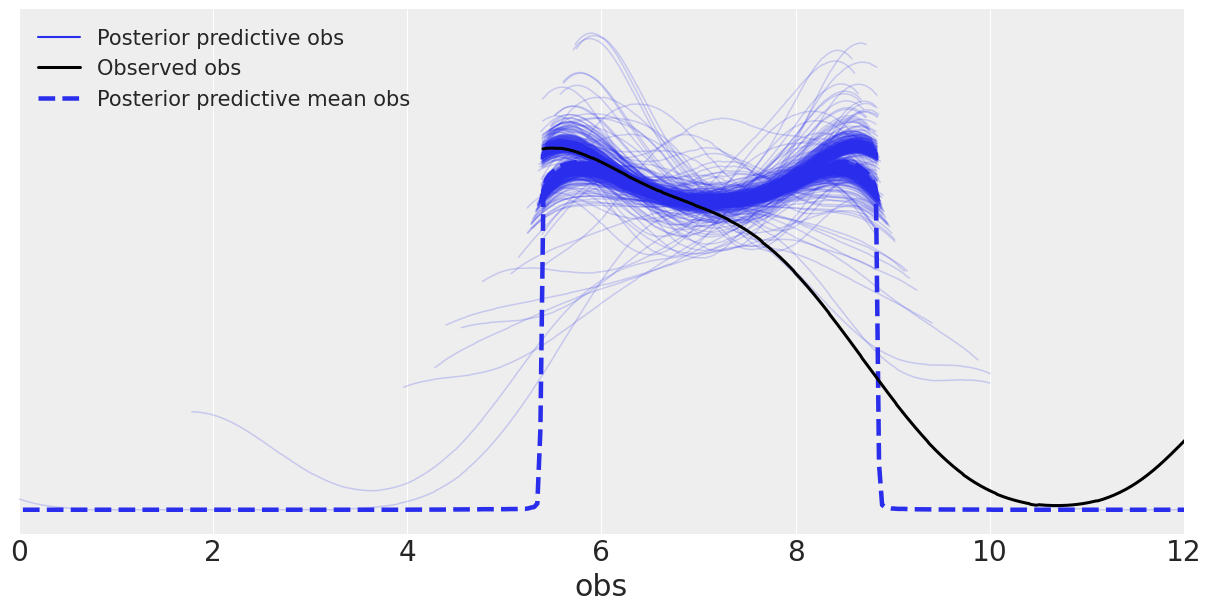

In [129]:
# data_ppc = az.from_pymc3(trace=trace_t, posterior_predictive=ppc)
ax = az.plot_ppc(pyro_data, figsize=(12, 6), mean=True)
plt.xlim(0, 12)
# plt.savefig('B11197_03_12.png', dpi=300)

## Hierarchical linear regression

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


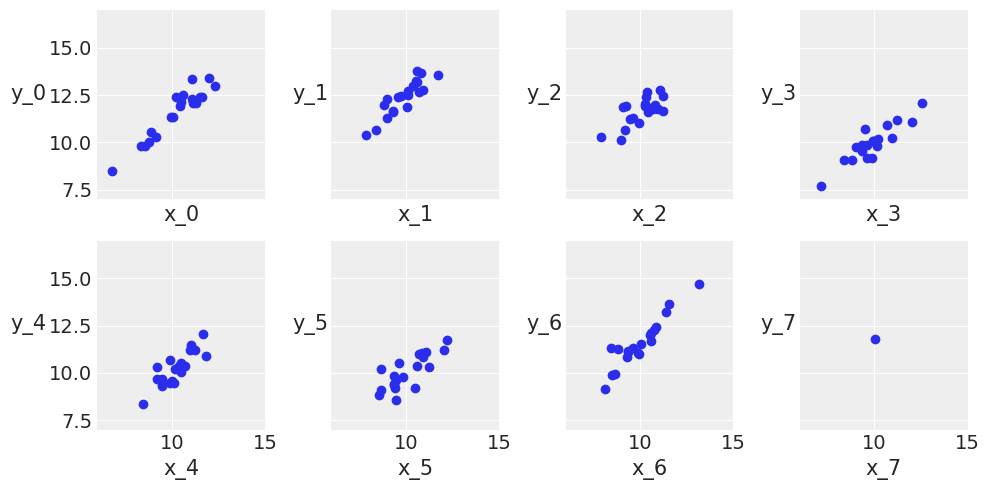

In [130]:
N = 20
M = 8
idx = np.repeat(range(M-1), N)
idx = np.append(idx, 7)
np.random.seed(314)

alpha_real = np.random.normal(2.5, 0.5, size=M)
beta_real = np.random.beta(6, 1, size=M)
eps_real = np.random.normal(0, 0.5, size=len(idx))

y_m = np.zeros(len(idx))
x_m = np.random.normal(10, 1, len(idx))
y_m = alpha_real[idx] + beta_real[idx] * x_m + eps_real

_, ax = plt.subplots(2, 4, figsize=(10, 5), sharex=True, sharey=True)
ax = np.ravel(ax)
j, k = 0, N
for i in range(M):
    ax[i].scatter(x_m[j:k], y_m[j:k])
    ax[i].set_xlabel(f'x_{i}')
    ax[i].set_ylabel(f'y_{i}', rotation=0, labelpad=15)
    ax[i].set_xlim(6, 15)
    ax[i].set_ylim(7, 17)
    j += N
    k += N
plt.tight_layout()
plt.savefig('B11197_03_13.png', dpi=300)

In [131]:
x_centered = x_m - x_m.mean()

### unpooled (non-hierarchical) mode

In [161]:
pyro.sample('alpha', dist.Normal(loc=torch.zeros(8), scale=1))

tensor([-0.1276, -0.8039,  0.0963, -1.6277, -0.5415,  0.0340,  0.7069,  0.2254])

In [157]:
 pyro.sample("mu_a", dist.Normal(0., 100.)).expand(4)

tensor([-20.0728, -20.0728, -20.0728, -20.0728])

In [163]:
pyro.sample('alpha', dist.Normal(loc=torch.zeros(M), scale=10))

tensor([26.1067, -6.3754,  3.4858,  9.8517, -5.9121,  5.7778, 19.4567, -2.9369])

In [232]:
def model_unpooled(idx, M, x, y=None):
    x_centered = x - x.mean()
    
    alpha_tmp = pyro.sample('alpha_tmp', dist.Normal(loc=torch.zeros(M), scale=10)).to(device)
    beta = pyro.sample('beta', dist.Normal(loc=torch.zeros(M), scale=10)).to(device)
    eps = pyro.sample('eps', dist.HalfCauchy(5.)).to(device)
    nu = pyro.sample('nu_', dist.Exponential(1/30)).to(device) 
    
    mu = alpha_tmp[idx] + beta[idx] * x_centered
    
    # add deterministric
    alpha = deterministic('alpha', alpha_tmp - beta * x.mean(), 0)
    
    if use_cuda:
        with pyro.plate("plate", size=x.shape[0], use_cuda=use_cuda):
            return pyro.sample("obs", dist.StudentT(df=nu, loc=mu, scale=eps), obs=y)
    else:
        with pyro.plate("plate", size=x.shape[0], use_cuda=None):
            return pyro.sample("obs", dist.StudentT(df=nu, loc=mu, scale=eps), obs=y)

### MCMC

In [226]:
%%time
pyro.clear_param_store() 

nuts_kernel = NUTS(model_unpooled)
mcmc = MCMC(nuts_kernel, num_samples=2000, warmup_steps=1000, num_chains=1)
# mcmc = MCMC(nuts_kernel, num_samples=200, warmup_steps=50, num_chains=1)
mcmc.run(idx, M, x_tensor, y_tensor)
posterior_samples = mcmc.get_samples()

Sample: 100%|██████████| 3000/3000 [01:04, 46.18it/s, step size=5.52e-01, acc. prob=0.893]

CPU times: user 1min 4s, sys: 256 ms, total: 1min 4s
Wall time: 1min 4s


In [227]:
mcmc.summary()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
alpha_tmp[0]     11.41      0.10     11.41     11.24     11.57   4243.56      1.00
alpha_tmp[1]     12.52      0.11     12.52     12.34     12.68   3267.68      1.00
alpha_tmp[2]     11.64      0.11     11.64     11.48     11.83   4175.48      1.00
alpha_tmp[3]     10.08      0.11     10.08      9.91     10.26   4595.07      1.00
alpha_tmp[4]     10.06      0.11     10.05      9.88     10.23   3869.34      1.00
alpha_tmp[5]     10.03      0.11     10.03      9.84     10.19   3670.40      1.00
alpha_tmp[6]     11.64      0.11     11.64     11.45     11.83   3882.01      1.00
alpha_tmp[7]     11.77      0.49     11.77     10.98     12.59   3915.52      1.00
     beta[0]      0.89      0.08      0.90      0.76      1.02   3046.61      1.00
     beta[1]      0.88      0.12      0.88      0.69      1.06   3847.65      1.00
     beta[2]      0.59      0.13      0.59      0.38      0.82   3707.20      1.00
   

In [228]:
posterior_samples

{'alpha_tmp': tensor([[11.5656, 12.5209, 11.6192,  ..., 10.0480, 11.6880, 11.8173],
         [11.4657, 12.4930, 11.6592,  ..., 10.0686, 11.5679, 11.7593],
         [11.3317, 12.6032, 11.4330,  ..., 10.1137, 11.8467, 10.8332],
         ...,
         [11.4164, 12.5373, 11.6492,  ..., 10.0015, 11.5000, 11.7096],
         [11.4637, 12.6051, 11.6413,  ...,  9.9803, 11.6882, 11.7791],
         [11.4714, 12.5157, 11.5817,  ..., 10.1304, 11.5017, 11.8084]],
        dtype=torch.float64),
 'beta': tensor([[  0.9187,   0.8600,   0.5766,  ...,   0.6430,   0.9166, -11.9078],
         [  0.8753,   0.8075,   0.4786,  ...,   0.6084,   0.8500, -13.8887],
         [  0.8756,   0.8548,   0.6765,  ...,   0.5460,   0.8179,  -1.3027],
         ...,
         [  0.8180,   0.8912,   0.4051,  ...,   0.5961,   1.0859,  14.4180],
         [  0.8981,   1.0285,   0.7791,  ...,   0.7436,   0.9950, -13.1496],
         [  0.7920,   0.7861,   0.3421,  ...,   0.6266,   0.9200,   4.0950]],
        dtype=torch.float64),
 

In [229]:
posterior_predictive = Predictive(model_unpooled, posterior_samples)(idx, M, x_tensor, None)
posterior_predictive

{'obs': tensor([[12.0834, 13.4753, 11.1768,  ..., 12.1547, 12.3051, 11.6351],
         [11.5750, 13.7126, 11.1936,  ..., 12.7381, 12.1507, 12.0579],
         [11.1533, 13.3854, 11.3295,  ..., 14.0430, 12.2779, 11.7536],
         ...,
         [11.8020, 13.4913, 11.1366,  ..., 12.5440, 12.2965, 11.4278],
         [10.3125, 12.7710, 11.6742,  ..., 13.8312, 12.2712, 11.3882],
         [10.8868, 13.4085, 11.8215,  ..., 12.9204, 12.3347, 11.5199]],
        dtype=torch.float64),
 'alpha': tensor([[   2.3402,    3.8842,    5.8287,  ...,    3.5908,    2.4834,
           131.3969],
         [   2.6760,    4.3837,    6.8527,  ...,    3.9592,    3.0320,
           151.2316],
         [   2.5383,    4.0187,    4.6398,  ...,    4.6306,    3.6336,
            23.9151],
         ...,
         [   3.2015,    3.5876,    7.5809,  ...,    4.0156,    0.5952,
          -133.0785],
         [   2.4448,    2.2768,    3.8174,  ...,    2.5128,    1.6958,
           143.8297],
         [   3.5181,    4.6218,   

### Summary table

#### version 1

In [239]:
get_summary_table(posterior_predictive, ['obs', 'alpha'])

{'obs':           mean       std     median       5.0%      95.0%
 0    11.341798  0.471718  11.350729  10.573166  12.106627
 1    13.433257  0.530608  13.437724  12.525308  14.231370
 2    11.435353  0.488390  11.438238  10.625790  12.231675
 3    11.584963  0.508081  11.576673  10.745689  12.426534
 4    12.412567  0.488002  12.407183  11.582908  13.180275
 ..         ...       ...        ...        ...        ...
 136  12.179048  0.501916  12.182834  11.365556  12.984034
 137  14.676772  0.583471  14.672466  13.742093  15.614728
 138  13.098463  0.514861  13.096126  12.340687  14.042952
 139  12.418713  0.502845  12.420518  11.646623  13.269718
 140  11.779671  0.673657  11.774504  10.673081  12.884094
 
 [141 rows x 5 columns],
 'alpha':         mean        std     median        5.0%       95.0%
 0   2.424015   0.801793   2.414826    1.154106    3.748151
 1   3.681404   1.156488   3.705864    1.831961    5.590852
 2   5.676059   1.339746   5.669472    3.519233    7.869307
 3   3.06

In [240]:
get_summary_table(posterior_samples, ['alpha_tmp', 'beta', 'eps'])

{'alpha_tmp':         mean       std     median       5.0%      95.0%
 0  11.409668  0.104070  11.412222  11.238754  11.574463
 1  12.523595  0.105457  12.524392  12.341129  12.683640
 2  11.643508  0.108482  11.641930  11.475611  11.829705
 3  10.080493  0.110014  10.081772   9.905284  10.262462
 4  10.056266  0.108584  10.054077   9.875900  10.234777
 5  10.028978  0.109460  10.031851   9.835014  10.190151
 6  11.642617  0.113570  11.639531  11.453891  11.829229
 7  11.767692  0.491528  11.769208  10.976924  12.585214,
 'beta':        mean       std    median       5.0%      95.0%
 0  0.894793  0.077877  0.895823   0.761638   1.017156
 1  0.880507  0.116120  0.879557   0.685332   1.060841
 2  0.594240  0.132669  0.593550   0.384120   0.816650
 3  0.698995  0.088754  0.698473   0.562241   0.850347
 4  0.872136  0.128306  0.870501   0.656228   1.069418
 5  0.678198  0.100972  0.675705   0.515239   0.848056
 6  0.984433  0.088341  0.983476   0.854042   1.137752
 7 -0.021822  9.598570  0

#### version 2

In [241]:
get_summary_table_pandas(posterior_predictive, ['obs','alpha'], percentiles=[.05, 0.95])

{'obs':       count       mean       std        min         5%        50%        95%  \
 0    2000.0  11.341798  0.471718   9.352730  10.575292  11.350835  12.110279   
 1    2000.0  13.433257  0.530608  10.643343  12.559203  13.438993  14.286867   
 2    2000.0  11.435353  0.488390   9.831656  10.633775  11.438650  12.248461   
 3    2000.0  11.584963  0.508081   8.800712  10.754907  11.576791  12.450333   
 4    2000.0  12.412567  0.488002  10.655306  11.608999  12.407365  13.222974   
 ..      ...        ...       ...        ...        ...        ...        ...   
 136  2000.0  12.179048  0.501916   9.029813  11.367871  12.183308  12.990777   
 137  2000.0  14.676772  0.583471  12.364137  13.752077  14.672993  15.627330   
 138  2000.0  13.098463  0.514861  10.680632  12.264692  13.096136  13.979276   
 139  2000.0  12.418713  0.502845  10.659720  11.583107  12.420915  13.224700   
 140  2000.0  11.779671  0.673657   9.296331  10.680735  11.774715  12.900438   
 
            max  
 

In [243]:
get_summary_table_pandas(posterior_samples, ['alpha_tmp', 'beta', 'eps'], percentiles=[.05, 0.95])

{'alpha_tmp':     count       mean       std        min         5%        50%        95%  \
 0  2000.0  11.409668  0.104070  11.088059  11.240970  11.412395  11.576964   
 1  2000.0  12.523595  0.105457  12.151199  12.353690  12.524496  12.700239   
 2  2000.0  11.643508  0.108482  11.308177  11.465808  11.642000  11.824473   
 3  2000.0  10.080493  0.110014   9.712916   9.895403  10.081841  10.256654   
 4  2000.0  10.056266  0.108584   9.676790   9.876298  10.054129  10.234835   
 5  2000.0  10.028978  0.109460   9.672122   9.848221  10.031991  10.207345   
 6  2000.0  11.642617  0.113570  11.187561  11.458076  11.639568  11.836687   
 7  2000.0  11.767692  0.491528   9.776765  10.959877  11.770164  12.564777   
 
          max  
 0  11.709090  
 1  12.860776  
 2  12.034779  
 3  10.446412  
 4  10.406973  
 5  10.454650  
 6  12.079201  
 7  13.472214  ,
 'beta':     count      mean       std        min         5%       50%        95%  \
 0  2000.0  0.894793  0.077877   0.630026   

### plot trace

In [245]:
num_samples=2000
prior = Predictive(model_unpooled, num_samples=num_samples).get_samples(idx, M, x_tensor, y_tensor)

In [251]:
mcmc

In [246]:
pyro_data = az.from_pyro(
    mcmc,
    prior=prior,
    posterior_predictive=posterior_predictive
)
pyro_data

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pyro.py:153: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  "Could not get vectorized trace, log_likelihood group will be omitted. "


Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

In [255]:
posterior_predictive['alpha']

tensor([[   2.3402,    3.8842,    5.8287,  ...,    3.5908,    2.4834,
          131.3969],
        [   2.6760,    4.3837,    6.8527,  ...,    3.9592,    3.0320,
          151.2316],
        [   2.5383,    4.0187,    4.6398,  ...,    4.6306,    3.6336,
           23.9151],
        ...,
        [   3.2015,    3.5876,    7.5809,  ...,    4.0156,    0.5952,
         -133.0785],
        [   2.4448,    2.2768,    3.8174,  ...,    2.5128,    1.6958,
          143.8297],
        [   3.5181,    4.6218,    8.1462,  ...,    3.8385,    2.2633,
          -29.3140]], dtype=torch.float64)

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

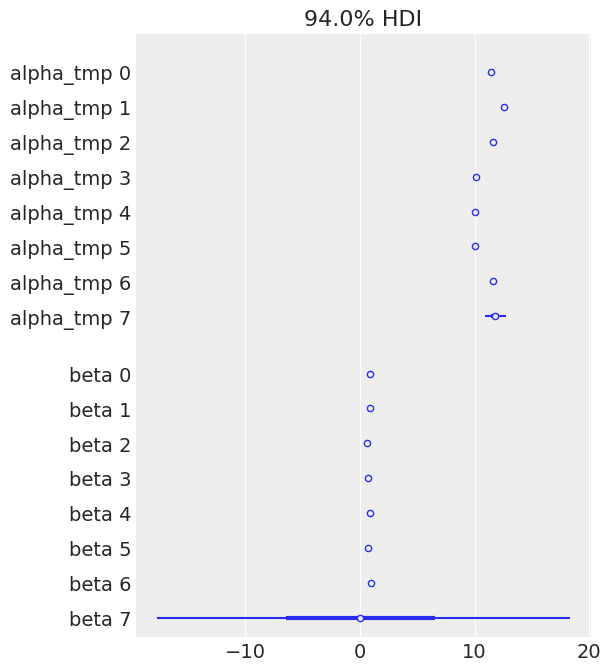

In [263]:
az.plot_forest(pyro_data, var_names=['alpha_tmp', 'beta'], combined=True)

In [264]:
def model_hierarchical(idx, M, x, y=None):
    x_centered = x - x.mean()
    
    # hyper-priors
    alpha_mu_tmp = pyro.sample('alpha_mu_tmp', dist.Normal(loc=0, scale=10)).to(device)
    alpha_sigma_tmp = pyro.sample('alpha_sigma_tmp', dist.HalfNormal(10.)).to(device)
    beta_mu = pyro.sample('beta_mu', dist.Normal(loc=0, scale=10)).to(device)
    beta_sigma_mu = pyro.sample('beta_sigma_mu', dist.HalfNormal(10.)).to(device)
    
    # prior
    alpha_tmp = pyro.sample('alpha_tmp', dist.Normal(loc=alpha_mu_tmp.expand(x.shape[0]), 
                                                     scale=alpha_sigma_tmp)).to(device)
    beta = pyro.sample('beta', dist.Normal(loc=beta_mu.expand(x.shape[0]),
                                           scale=beta_sigma_mu)).to(device)
    eps = pyro.sample('eps', dist.HalfCauchy(5.)).to(device)
    nu = pyro.sample('nu_', dist.Exponential(1/30)).to(device) 
    
    mu = alpha_tmp[idx] + beta[idx] * x_centered
    
    # add deterministric
    alpha = deterministic('alpha', alpha_tmp - beta * x.mean(), 0)
    alpha_mu = deterministic('alpha_mu', alpha_mu_tmp - beta_mu * x.mean(), 0)
    alpha_sigma = deterministic('alpha_sigma', alpha_sigma_tmp - beta_mu * x.mean(), 0)
    
    if use_cuda:
        with pyro.plate("plate", size=x.shape[0], use_cuda=use_cuda):
            return pyro.sample("obs", dist.StudentT(df=nu, loc=mu, scale=eps), obs=y)
    else:
        with pyro.plate("plate", size=x.shape[0], use_cuda=None):
            return pyro.sample("obs", dist.StudentT(df=nu, loc=mu, scale=eps), obs=y)

### MCMC

In [ ]:
%%time
pyro.clear_param_store() 

nuts_kernel = NUTS(model_hierarchical)
mcmc = MCMC(nuts_kernel, num_samples=2000, warmup_steps=1000, num_chains=1)
# mcmc = MCMC(nuts_kernel, num_samples=200, warmup_steps=50, num_chains=1)
mcmc.run(idx, M, x_tensor, y_tensor)
posterior_samples = mcmc.get_samples()

Warmup:  22%|██▏       | 659/3000 [03:54,  9.74it/s, step size=1.38e-01, acc. prob=0.786]

In [ ]:
mcmc.summary()

In [ ]:
posterior_samples

In [ ]:
posterior_predictive = Predictive(model_unpooled, posterior_samples)(idx, M, x_tensor, None)
posterior_predictive

### Summary table

#### version 1

In [ ]:
get_summary_table(posterior_predictive, ['obs', 'alpha'])

In [ ]:
get_summary_table(posterior_samples, ['alpha_tmp', 'beta', 'eps'])

#### version 2

In [ ]:
get_summary_table_pandas(posterior_predictive, ['obs','alpha'], percentiles=[.05, 0.95])

In [ ]:
get_summary_table_pandas(posterior_samples, ['alpha_tmp', 'beta', 'eps'], percentiles=[.05, 0.95])

### plot trace

In [ ]:
num_samples=2000
prior = Predictive(model_unpooled, num_samples=num_samples).get_samples(idx, M, x_tensor, y_tensor)

In [ ]:
mcmc

In [ ]:
pyro_data = az.from_pyro(
    mcmc,
    prior=prior,
    posterior_predictive=posterior_predictive
)
pyro_data

In [ ]:
posterior_predictive['alpha']

In [ ]:
az.plot_forest(pyro_data, var_names=['alpha_tmp', 'beta'], combined=True)

In [ ]:
_, ax = plt.subplots(2, 4, figsize=(10, 5), sharex=True, sharey=True,
                     constrained_layout=True)
ax = np.ravel(ax)
j, k = 0, N
x_range = np.linspace(x_m.min(), x_m.max(), 10)
for i in range(M):
    ax[i].scatter(x_m[j:k], y_m[j:k])
    ax[i].set_xlabel(f'x_{i}')
    ax[i].set_ylabel(f'y_{i}', labelpad=17, rotation=0)
    # 
    alpha_m = get_summary_table(posterior_samples, ['alpha'], diagnostics=False, group_by_chain=False, prob=0.9)['alpha']['mean'].values[0]
    beta_m = get_summary_table(posterior_samples, ['beta'], diagnostics=False, group_by_chain=False, prob=0.9)['beta']['mean'].values[0]
    
    
#     alpha_m = trace_hm['α'][:, i].mean()
#     beta_m = trace_hm['β'][:, i].mean()
    ax[i].plot(x_range, alpha_m + beta_m * x_range, c='k',
               label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')
    plt.xlim(x_m.min()-1, x_m.max()+1)
    plt.ylim(y_m.min()-1, y_m.max()+1)
    j += N
    k += N
# plt.savefig('B11197_03_17.png', dpi=300)

## Polynomial regression

In [ ]:
x_2 = ans[ans.group == 'II']['x'].values
y_2 = ans[ans.group == 'II']['y'].values
x_2 = x_2 - x_2.mean()

plt.scatter(x_2, y_2)
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.savefig('B11197_03_18.png', dpi=300)

In [ ]:
with pm.Model() as model_poly:
    alpha = pm.Normal('alpha', mu=y_2.mean(), sd=1)
    beta1 = pm.Normal('beta1', mu=0, sd=1)
    beta2 = pm.Normal('beta2', mu=0, sd=1)
    eps = pm.HalfCauchy('eps', 5)

    mu = alpha + beta1 * x_2 + beta2 * x_2**2

    y_pred = pm.Normal('y_pred', mu=mu, sd=eps, observed=y_2)

    trace_poly = pm.sample(2000)

In [ ]:
#az.plot_trace(trace_poly);

In [ ]:
#az.summary(trace_poly)

In [ ]:
x_p = np.linspace(-6, 6)
y_p = trace_poly['alpha'].mean() + trace_poly['beta1'].mean() * \
    x_p + trace_poly['beta2'].mean() * x_p**2
plt.scatter(x_2, y_2)
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.plot(x_p, y_p, c='C1')
plt.savefig('B11197_03_19.png', dpi=300)

## Multiple Linear regression

In [ ]:
np.random.seed(314)
N = 100
alpha_real = 2.5
beta_real = [0.9, 1.5]
eps_real = np.random.normal(0, 0.5, size=N)

X = np.array([np.random.normal(i, j, N) for i, j in zip([10, 2], [1, 1.5])]).T
X_mean = X.mean(axis=0, keepdims=True)
X_centered = X - X_mean
y = alpha_real + np.dot(X, beta_real) + eps_real

In [ ]:
def scatter_plot(x, y):
    plt.figure(figsize=(10, 10))
    for idx, x_i in enumerate(x.T):
        plt.subplot(2, 2, idx+1)
        plt.scatter(x_i, y)
        plt.xlabel(f'x_{idx+1}')
        plt.ylabel(f'y', rotation=0)

    plt.subplot(2, 2, idx+2)
    plt.scatter(x[:, 0], x[:, 1])
    plt.xlabel(f'x_{idx}')
    plt.ylabel(f'x_{idx+1}', rotation=0)

scatter_plot(X_centered, y)
plt.savefig('B11197_03_20.png', dpi=300)

In [ ]:
with pm.Model() as model_mlr:
    alpha_tmp = pm.Normal('alpha_tmp', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1, shape=2)
    eps = pm.HalfCauchy('eps', 5)

    mu = alpha_tmp + pm.math.dot(X_centered, beta)

    alpha = pm.Deterministic('alpha', alpha_tmp - pm.math.dot(X_mean, beta))

    y_pred = pm.Normal('y_pred', mu=mu, sd=eps, observed=y)

    trace_mlr = pm.sample(2000)

In [ ]:
varnames = ['alpha', 'beta', 'eps']
#az.plot_trace(trace_mlr, var_names=varnames);

In [ ]:
az.summary(trace_mlr, var_names=varnames)

## Confounding variables and redundant variables

In [ ]:
np.random.seed(42)
N = 100
x_1 = np.random.normal(size=N)
x_2 = x_1 + np.random.normal(size=N, scale=1)
#x_2 = x_1 + np.random.normal(size=N, scale=0.01)
y = x_1 + np.random.normal(size=N)
X = np.vstack((x_1, x_2)).T

In [ ]:
scatter_plot(X, y)
plt.savefig('B11197_03_21.png', dpi=300)

In [ ]:
with pm.Model() as m_x1x2:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta1 = pm.Normal('beta1', mu=0, sd=10)
    beta2 = pm.Normal('beta2', mu=0, sd=10)
    eps = pm.HalfCauchy('eps', 5)

    mu = alpha + beta1 * X[:, 0] + beta2 * X[:, 1]

    y_pred = pm.Normal('y_pred', mu=mu, sd=eps, observed=y)

    trace_x1x2 = pm.sample(2000)


with pm.Model() as m_x1:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta1 = pm.Normal('beta1', mu=0, sd=10)
    eps = pm.HalfCauchy('eps', 5)

    mu = alpha + beta1 * X[:, 0]

    y_pred = pm.Normal('y_pred', mu=mu, sd=eps, observed=y)

    trace_x1 = pm.sample(2000)

with pm.Model() as m_x2:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta2 = pm.Normal('beta2', mu=0, sd=10)
    eps = pm.HalfCauchy('eps', 5)

    mu = alpha + beta2 * X[:, 1]

    y_pred = pm.Normal('y_pred', mu=mu, sd=eps, observed=y)

    trace_x2 = pm.sample(2000)

In [ ]:
az.plot_forest([trace_x1x2, trace_x1, trace_x2],
               model_names=['m_x1x2', 'm_x1', 'm_x2'],
               var_names=['beta1', 'beta2'],
               combined=False, colors='cycle', figsize=(8, 3))
plt.savefig('B11197_03_22.png', dpi=300)

In [ ]:
# just repeating the code from a couple of cells before, but with a lower value of `scale`.
np.random.seed(42)
N = 100
x_1 = np.random.normal(size=N)
x_2 = x_1 + np.random.normal(size=N, scale=0.01)
y = x_1 + np.random.normal(size=N)
X = np.vstack((x_1, x_2)).T

In [ ]:
scatter_plot(X, y)
plt.savefig('B11197_03_23.png', dpi=300)

In [ ]:
with pm.Model() as model_red:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    eps = pm.HalfCauchy('eps', 5)

    mu = alpha + pm.math.dot(X, beta)

    y_pred = pm.Normal('y_pred', mu=mu, sd=eps, observed=y)

    trace_red = pm.sample(2000)

In [ ]:
az.plot_forest(trace_red, var_names=['beta'], combined=True, figsize=(8, 2))
plt.savefig('B11197_03_24.png', dpi=300)

In [ ]:
az.plot_pair(trace_red, var_names=['beta'])
plt.savefig('B11197_03_25.png', dpi=300)

## Masking effect variables

In [ ]:
np.random.seed(42)
N = 126
r = 0.8
x_1 = np.random.normal(size=N)
x_2 = np.random.normal(x_1, scale=(1 - r ** 2) ** 0.5)
y = np.random.normal(x_1 - x_2)
X = np.vstack((x_1, x_2)).T

In [ ]:
scatter_plot(X, y)
plt.savefig('B11197_03_26.png', dpi=300, figsize=(5.5, 5.5))

In [ ]:
with pm.Model() as m_x1x2:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta1 = pm.Normal('beta1', mu=0, sd=10)
    beta2 = pm.Normal('beta2', mu=0, sd=10)
    eps = pm.HalfCauchy('eps', 5)

    mu = alpha + beta1 * X[:, 0] + beta2 * X[:, 1]

    y_pred = pm.Normal('y_pred', mu=mu, sd=eps, observed=y)

    trace_x1x2 = pm.sample(1000)


with pm.Model() as m_x1:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta1 = pm.Normal('beta1', mu=0, sd=10)
    eps = pm.HalfCauchy('eps', 5)

    mu = alpha + beta1 * X[:, 0]

    y_pred = pm.Normal('y_pred', mu=mu, sd=eps, observed=y)

    trace_x1 = pm.sample(1000)

with pm.Model() as m_x2:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta2 = pm.Normal('beta2', mu=0, sd=10)
    eps = pm.HalfCauchy('eps', 5)

    mu = alpha + beta2 * X[:, 1]

    y_pred = pm.Normal('y_pred', mu=mu, sd=eps, observed=y)

    trace_x2 = pm.sample(1000)

In [ ]:
az.plot_forest([trace_x1x2, trace_x1, trace_x2],
               model_names=['m_x1x2', 'm_x1', 'm_x2'],
               var_names=['beta1', 'beta2'],
               combined=True, colors='cycle', figsize=(8, 3))
plt.savefig('B11197_03_27.png', dpi=300, bbox_inches='tight')

## Variable variance

In [ ]:
data = pd.read_csv('../data/babies.csv')
data.plot.scatter('Month', 'Lenght')
plt.savefig('B11197_03_28.png', dpi=300)

In [ ]:
with pm.Model() as model_vv:
    alpha = pm.Normal('alpha', sd=10)
    beta = pm.Normal('beta', sd=10)
    γ = pm.HalfNormal('γ', sd=10)
    δ = pm.HalfNormal('δ', sd=10)

    x_shared = shared(data.Month.values * 1.)

    mu = pm.Deterministic('mu', alpha + beta * x_shared**0.5)
    eps = pm.Deterministic('eps', γ + δ * x_shared)

    y_pred = pm.Normal('y_pred', mu=mu, sd=eps, observed=data.Lenght)

    trace_vv = pm.sample(1000, tune=1000)

In [ ]:
plt.plot(data.Month, data.Lenght, 'C0.', alpha=0.1)

mu_m = trace_vv['mu'].mean(0)
eps_m = trace_vv['eps'].mean(0)

plt.plot(data.Month, mu_m, c='k')
plt.fill_between(data.Month, mu_m + 1 * eps_m, mu_m -
                 1 * eps_m, alpha=0.6, color='C1')
plt.fill_between(data.Month, mu_m + 2 * eps_m, mu_m -
                 2 * eps_m, alpha=0.4, color='C1')

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.savefig('B11197_03_29.png', dpi=300)

In [ ]:
x_shared.set_value([0.5])
ppc = pm.sample_posterior_predictive(trace_vv, 2000, model=model_vv)
y_ppc = ppc['y_pred'][:, 0]

In [ ]:
ref = 53
density, l, u = az._fast_kde(y_ppc)
x_ = np.linspace(l, u, 200)
plt.plot(x_, density)
percentile = int(sum(y_ppc <= ref) / len(y_ppc) * 100)
plt.fill_between(x_[x_ < ref], density[x_ < ref],
                 label='percentile = {:2d}'.format(percentile))
plt.xlabel('length')
plt.yticks([])
plt.legend()
plt.savefig('B11197_03_30.png', dpi=300)

In [ ]:
x_4 = ans[ans.group == 'IV']['x'].values
y_4 = ans[ans.group == 'IV']['y'].values

with pm.Model() as model_t2:
    alpha = pm.Normal('alpha', mu=0, sd=100)
    beta = pm.Normal('beta', mu=0, sd=1)
    eps = pm.HalfCauchy('eps', 5)
    ν = pm.Exponential('ν', 1/30)
    #ν = pm.Gamma('ν', mu=20, sd=15)
    #ν = pm.Gamma('ν', 2, 0.1)

    y_pred = pm.StudentT('y_pred', mu=alpha + beta * x_4, sd=eps, nu=ν, observed=y_4)
    trace_t2 = pm.sample(2000)